### Part A – Q1: Load Feature Matrix (X) and Label Matrix (Y)

We load the Yeast dataset using the `.arff` and `.xml` files. The XML file is used to identify the 14 multi-label targets. All other columns are treated as features. The expected dimensions are:

- 103 features
- 14 labels

We store:
- `X`: feature matrix (`float32`)
- `Y`: binary multi-label target matrix (`int8`)

In [ ]:
import pandas as pd
import numpy as np
from scipy.io import arff
import xml.etree.ElementTree as ET

# Load ARFF data
data, meta = arff.loadarff("yeast.arff")
df = pd.DataFrame(data)

# Decode byte strings
df = df.map(lambda x: x.decode("utf-8") if isinstance(x, bytes) else x)

# Normalize column names for case-insensitive match
df.columns = [col.strip().lower() for col in df.columns]

# Parse labels from XML
tree = ET.parse("yeast.xml")
root = tree.getroot()
ns = {'mulan': root.tag.split('}')[0].strip('{')}  # Extract namespace from root tag
raw_labels = [elem.attrib["name"].strip().lower() for elem in root.findall("mulan:label", namespaces=ns)]

# Match label columns from ARFF with labels from XML
label_cols = [col for col in df.columns if col in raw_labels]
feature_cols = [col for col in df.columns if col not in label_cols]

# Extract X and Y
X = df[feature_cols].astype(np.float32).values
Y = df[label_cols].astype(np.int8).values

print(f"Number of data points: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of labels: {Y.shape[1]}")

Number of data points: 2417
Number of features: 103
Number of labels: 14


### Part A – Q2: Dimensionality Check

We verify the dimensions of the feature matrix `X` and label matrix `Y` after loading:

- Number of data points: 2417
- Number of features: 103
- Number of labels: 14

This confirms that the dataset has been loaded correctly and is consistent with the problem specification.

### Part A – Q3: Label Selection for Visualization

To reduce visual clutter caused by 14 classes, we define a simplified categorical variable for coloring:

1. Identify the two most frequent single-label classes (i.e., samples with exactly one label).
2. Identify the most common multi-label combination (samples with more than one active label).
3. All other cases are grouped under `"Other"`.

This new variable `label_viz` will be used to color scatter plots in later parts of the assignment.

In [19]:
import pandas as pd
from collections import Counter

# Convert Y to DataFrame for readability
Y_df = pd.DataFrame(Y, columns=label_cols)
label_sums = Y_df.sum(axis=1)

# --- SINGLE-LABEL: Get top 2 classes
single_label_rows = Y_df[label_sums == 1]
single_label_counts = single_label_rows.sum().sort_values(ascending=False)
top_single_labels = list(single_label_counts.index[:2])
print("Top 2 single-label classes:", top_single_labels)
print("Counts:\n", single_label_counts[:2])

# --- MULTI-LABEL: Most common label combination
multi_label_rows = Y_df[label_sums > 1]
multi_label_tuples = [tuple(row) for row in multi_label_rows.values]
multi_label_combo_counts = Counter(multi_label_tuples)
top_multi_combo, top_multi_count = multi_label_combo_counts.most_common(1)[0]
print(f"\nTop multi-label combination occurs {top_multi_count} times")
top_multi_labels = [label_cols[i] for i, v in enumerate(top_multi_combo) if v == 1]
print("Labels in top multi-label combo:", top_multi_labels)

# --- Assign class index
label_viz = []
for i in range(Y.shape[0]):
    row = tuple(Y[i])
    if sum(row) == 1:
        label_idx = row.index(1)
        label_name = label_cols[label_idx]
        if label_name in top_single_labels:
            label_viz.append(label_name)
        else:
            label_viz.append("Other")
    elif row == top_multi_combo:
        label_viz.append("Top Multi")
    else:
        label_viz.append("Other")

label_viz = pd.Series(label_viz, name="label_viz")
print("\nSimplified label distribution:")
print(label_viz.value_counts())

Top 2 single-label classes: ['class1', 'class2']
Counts:
 class1    32
class2     0
dtype: int64

Top multi-label combination occurs 237 times
Labels in top multi-label combo: ['class3', 'class4', 'class12', 'class13']

Simplified label distribution:
label_viz
Other        2148
Top Multi     237
class1         32
Name: count, dtype: int64


The label distribution after simplification is as follows:

- `class1`: 32 samples (top single-label class)
- `class2`: 0 samples (second most frequent single-label class by rank, but no data points)
- `Top Multi`: 237 samples with the label combination ['class3', 'class4', 'class12', 'class13']
- `Other`: 2148 samples

Since `class2` has zero occurrences, we discard it.  
We proceed with **only three visualization categories**:

1. `class1`
2. `Top Multi`
3. `Other`

This reduced set ensures clarity and interpretability in the upcoming t-SNE and Isomap plots.

### Part A – Q4: Feature Scaling

t-SNE and Isomap are both distance-based dimensionality reduction techniques. Feature scaling is critical before applying these methods because:

- Features with large numeric ranges can dominate Euclidean distances.
- Unscaled data can lead to distorted neighborhood relationships.
- Standardization ensures that each feature contributes equally by converting values to zero mean and unit variance.

We apply standard scaling to the feature matrix `X`, and store the result as `X_scaled`.

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Shape after scaling:", X_scaled.shape)
print("Mean of first 5 features (approx.):", X_scaled[:, :5].mean(axis=0))
print("Std of first 5 features (approx.):", X_scaled[:, :5].std(axis=0))

Shape after scaling: (2417, 103)
Mean of first 5 features (approx.): [ 0.0000000e+00 -8.6805274e-09  1.4993638e-08  1.4993638e-08
  1.1837083e-08]
Std of first 5 features (approx.): [1. 1. 1. 1. 1.]


### Part B – Q1: t-SNE Implementation

We apply t-SNE on the standardized feature matrix `X_scaled` to reduce it to 2D. The core hyperparameter in t-SNE is **perplexity**, which controls the balance between local and global structure in the data.

We explore the effect of perplexity by running t-SNE for the following values:
- Perplexity values tried: [5, 10, 20, 30, 40, 50, 75, 100]

For each run, we store the 2D embedding and visualize the result using the simplified label classes:

- `class1`
- `Top Multi`
- `Other`

This helps assess which value offers the clearest separation for downstream analysis.

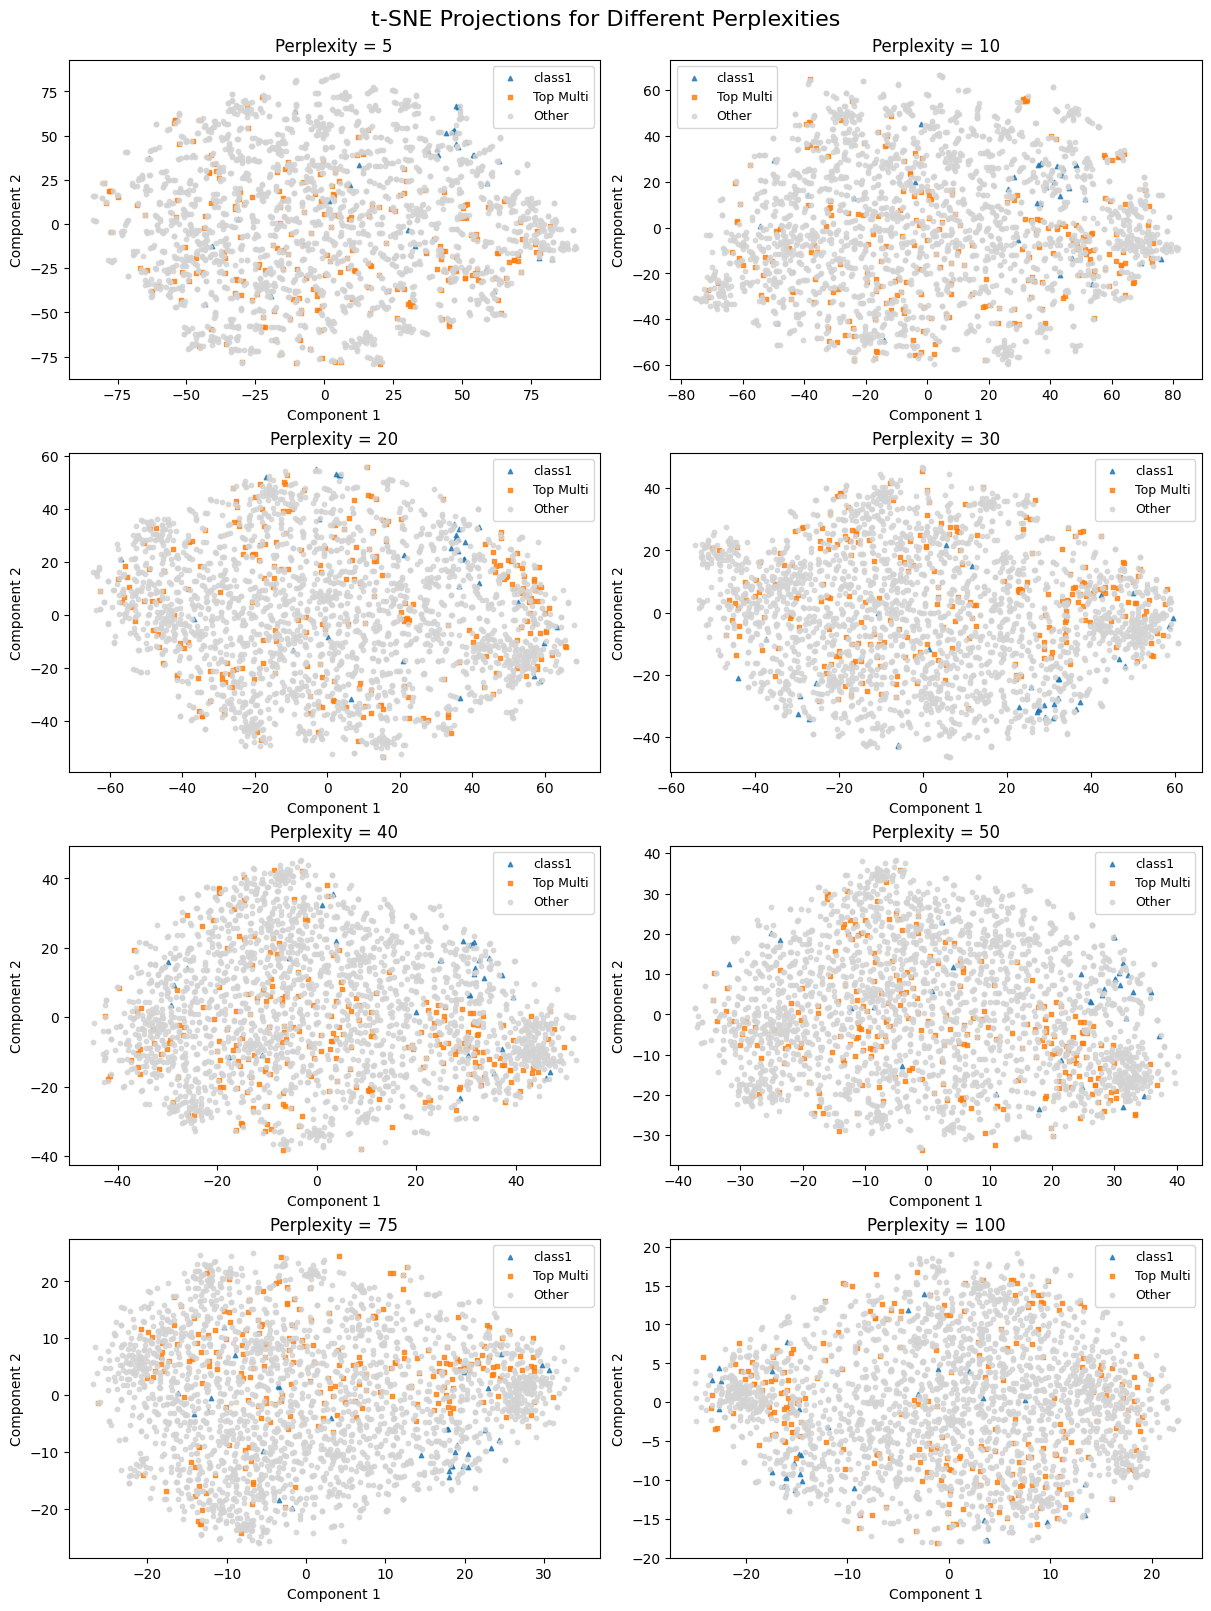

In [25]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Run t-SNE for different perplexities
RANDOM_STATE = 42
perplexities = [5, 10, 20, 30, 40, 50, 75, 100]
tsne_results = {}

for p in perplexities:
    tsne = TSNE(n_components=2, perplexity=p, random_state=RANDOM_STATE, init="pca", learning_rate="auto")
    X_tsne = tsne.fit_transform(X_scaled)
    tsne_results[p] = X_tsne
    # print(f"Perplexity {p}: shape = {X_tsne.shape}")

# Create label DataFrame
df_tsne = pd.DataFrame({'label_viz': label_viz})

# Define consistent palette and markers
palette = {
    "class1": "#1f77b4",      # blue
    "Top Multi": "#ff7f0e",   # orange
    "Other": "#d3d3d3"        # light gray
}

markers = {
    "class1": "^",
    "Top Multi": "s",
    "Other": "o"
}

# Grid: 4 rows x 2 columns
n_rows, n_cols = 4, 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 4*n_rows), constrained_layout=True)
axes = axes.flatten()

for i, p in enumerate(perplexities):
    coords = tsne_results[p]
    df_tsne['x'] = coords[:, 0]
    df_tsne['y'] = coords[:, 1]

    ax = axes[i]
    for label in palette.keys():
        subset = df_tsne[df_tsne['label_viz'] == label]
        ax.scatter(
            subset['x'], subset['y'],
            label=label,
            color=palette[label],
            marker=markers[label],
            s=10,
            alpha=0.8
        )
    
    ax.set_title(f"Perplexity = {p}", fontsize=12)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(fontsize=9, loc='best', frameon=True)

# Hide unused axes
for i in range(len(perplexities), len(axes)):
    axes[i].set_visible(False)

plt.suptitle("t-SNE Projections for Different Perplexities", fontsize=16)
plt.show()

We evaluated t-SNE projections for perplexity values ranging from 5 to 100. At very low perplexities (5, 10), the embeddings were noisy and lacked clear structure. At very high values (75, 100), the embeddings became overly compressed, reducing the visible separation between clusters.

Perplexity values between 30 and 50 provided the best balance between local and global structure. Among these, **perplexity = 40** gave the most interpretable plot:
- `class1` and `Top Multi` are moderately separated from the `Other` class.
- The overall layout is stable and not overly stretched or collapsed.

We proceed with **perplexity = 40** for downstream analysis.

### Part B – Q2: Final t‑SNE Visualization (Perplexity = 40)

We plot the 2D t‑SNE embedding computed on `X_scaled` with **perplexity = 40** (selected in Q1).  

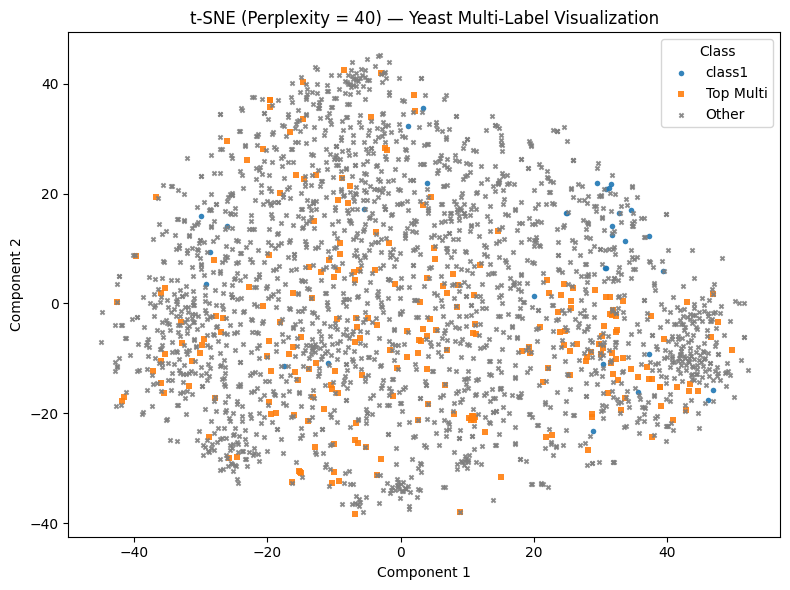

In [28]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Use existing embedding if present; else compute
PERP = 40
if "tsne_results" in globals() and PERP in tsne_results:
    X_tsne = tsne_results[PERP]
else:
    X_tsne = TSNE(n_components=2, perplexity=PERP, random_state=42, init="pca",
                  learning_rate="auto").fit_transform(X_scaled)

# Assemble plotting frame
plot_df = pd.DataFrame({
    "x": X_tsne[:, 0],
    "y": X_tsne[:, 1],
    "label_viz": label_viz.values
})

palette = {"class1": "#1f77b4", "Top Multi": "#ff7f0e", "Other": "#7f7f7f"}
markers = {"class1": "o", "Top Multi": "s", "Other": "X"}

plt.figure(figsize=(8, 6))
for lab in ["class1", "Top Multi", "Other"]:
    d = plot_df[plot_df["label_viz"] == lab]
    plt.scatter(d["x"], d["y"], s=16, marker=markers[lab], c=palette[lab], label=lab, alpha=0.9, linewidths=0)

plt.title("t‑SNE (Perplexity = 40) — Yeast Multi‑Label Visualization")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Class", frameon=True)
plt.tight_layout()
plt.show()

### Part B – Q3: Veracity Inspection from t‑SNE (Perplexity = 40)

We analyze the 2D t‑SNE projection for three key data veracity issues:  
**(a) Noisy/Ambiguous Labels**, **(b) Outliers**, and **(c) Hard‑to‑Learn Samples**.



#### (a) Noisy / Ambiguous Labels

Noisy samples are expected to appear **embedded within clusters of another class**.  
In the plot, several `class1` (blue) and `Top Multi` (orange) points are isolated within dense `Other` (gray) regions — e.g., between `x = 10 to 30` and `y = -20 to 0`. These likely correspond to misclassified or borderline samples, especially in biological data where gene functions overlap.



#### (b) Outliers

Outliers are seen as **sparsely located, isolated points or tiny clusters**.  
Examples:
- A few scattered `class1` points in the top-right and lower-left corners
- Isolated `Top Multi` points far from denser orange regions (e.g., near `x = -40`, `y = +40`)

These may represent gene expression profiles that are biologically rare or corrupted by noise during acquisition.



#### (c) Hard‑to‑Learn Samples

Hard regions are where **multiple classes are mixed without clear separation**, making decision boundaries fuzzy.  
This is especially visible in the central band (`x = -20 to 20`, `y = -10 to +10`), where `class1`, `Top Multi`, and `Other` samples are densely interleaved. A classifier operating here will struggle due to overlapping feature distributions and poor class separability.



**Conclusion**:  
The t‑SNE visualization reveals that a significant portion of the dataset suffers from veracity issues:
- Mislabeling or overlapping functions (ambiguity)
- Rare or extreme samples (outliers)
- Blended class distributions (difficulty in learning)

These insights are important when designing robust multi‑label classifiers or cleaning the dataset.


### Part C – Q1: Isomap Implementation

We apply **Isomap** on the standardized feature matrix `X_scaled` to obtain a 2D embedding for manifold visualization.  
To assess the stability of the embedding, we compute Isomap projections for the following values of `n_neighbors`:
- [5, 10, 15, 20]



#### Difference Between Isomap and t‑SNE in Terms of Structure Preservation

**t‑SNE** focuses on preserving **local neighborhood structure**. It attempts to maintain the pairwise similarity of nearby points by converting distances to probabilities in both high‑ and low‑dimensional spaces. As a result, it can distort the **global geometry** of the data (e.g., relative positions of far-apart clusters may be unreliable), but it often reveals local clusters effectively.

**Isomap**, in contrast, is a **global manifold learning** algorithm. It:
- Builds a neighborhood graph from the data,
- Computes **geodesic distances** (shortest paths along the graph),
- And applies **Multidimensional Scaling (MDS)** on this geodesic distance matrix.

By using geodesic distances, Isomap captures both **local** and **global** structure, making it better at preserving the **intrinsic geometry** of curved manifolds. It is deterministic and more faithful to the overall shape of the data, especially when the manifold is smooth and well‑sampled.

We now proceed to visualize and compare the Isomap embeddings across different `n_neighbors` in Q2.


In [29]:
from sklearn.manifold import Isomap
import numpy as np

# Isomap over multiple neighborhood sizes
neighbors_list = [5, 10, 15, 20]
isomap_results = {}

for k in neighbors_list:
    iso = Isomap(n_neighbors=k, n_components=2, path_method='auto', neighbors_algorithm='auto')
    X_iso = iso.fit_transform(X_scaled)
    isomap_results[k] = X_iso
    print(f"n_neighbors = {k}: embedding shape = {X_iso.shape}")

n_neighbors = 5: embedding shape = (2417, 2)
n_neighbors = 10: embedding shape = (2417, 2)
n_neighbors = 15: embedding shape = (2417, 2)
n_neighbors = 20: embedding shape = (2417, 2)


### Part C – Q2: Isomap Visualization (2D)

We plot the 2D Isomap embeddings for four neighborhood sizes to assess stability and separability under the same coloring/marker scheme used for t‑SNE.

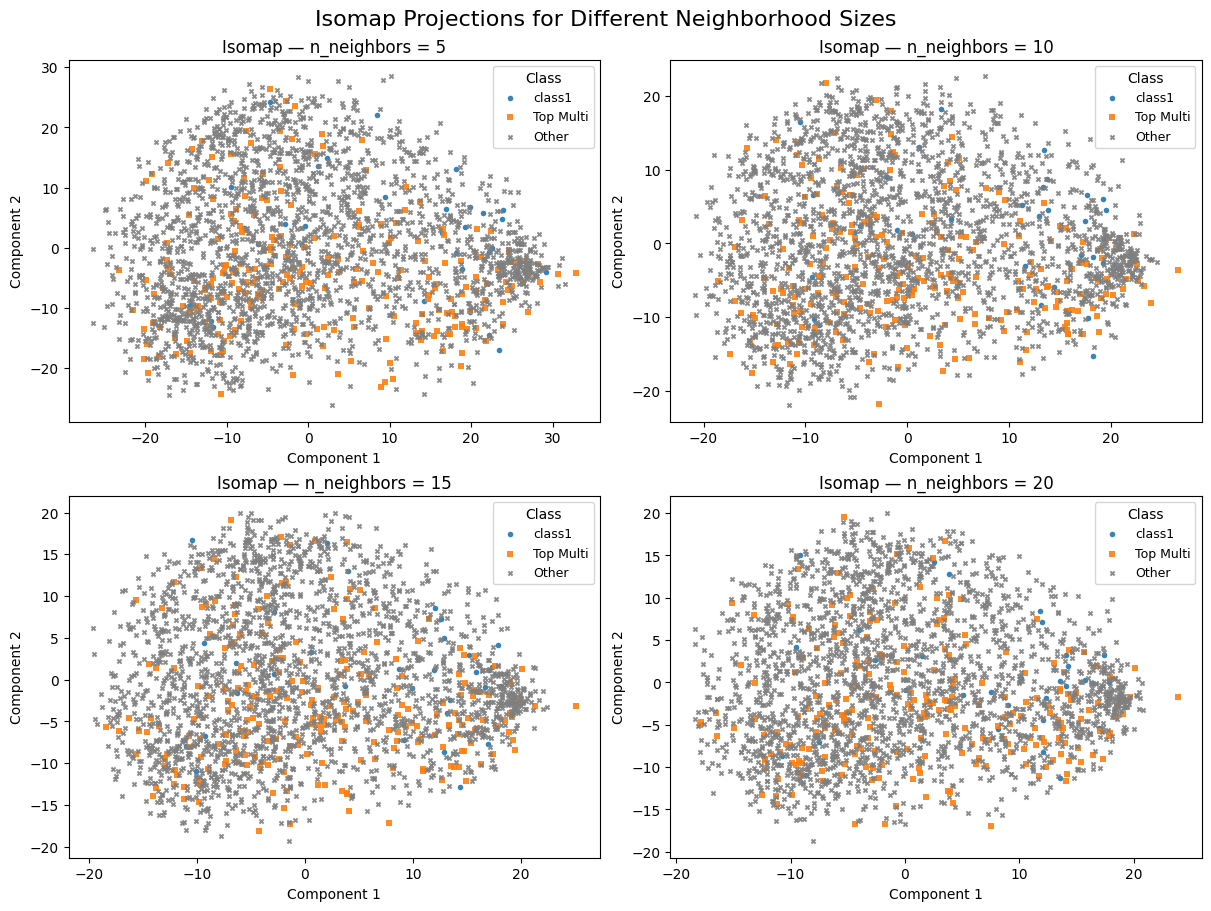

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.manifold import Isomap

# Ensure embeddings exist; if not, compute them
neighbors_list = [5, 10, 15, 20]
try:
    isomap_results
except NameError:
    isomap_results = {}
for k in neighbors_list:
        if k not in isomap_results:
            iso = Isomap(n_neighbors=k, n_components=2, path_method='auto', neighbors_algorithm='auto')
            isomap_results[k] = iso.fit_transform(X_scaled)

# Common palette and markers
palette = {"class1": "#1f77b4", "Top Multi": "#ff7f0e", "Other": "#7f7f7f"}
markers = {"class1": "o", "Top Multi": "s", "Other": "X"}

# Prepare label series once
labels = label_viz.values

# Plot grid: 2 × 2
fig, axes = plt.subplots(2, 2, figsize=(12, 9), constrained_layout=True)
axes = axes.flatten()

for ax, k in zip(axes, neighbors_list):
    emb = isomap_results[k]
    plot_df = pd.DataFrame({"x": emb[:, 0], "y": emb[:, 1], "label": labels})
    for lab in ["class1", "Top Multi", "Other"]:
        d = plot_df[plot_df["label"] == lab]
        ax.scatter(d["x"], d["y"], s=16, marker=markers[lab], c=palette[lab], label=lab, alpha=0.9, linewidths=0)
    ax.set_title(f"Isomap — n_neighbors = {k}", fontsize=12)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(title="Class", fontsize=9, frameon=True, loc="best")

plt.suptitle("Isomap Projections for Different Neighborhood Sizes", fontsize=16)
plt.show()

### Part C – Q3: Comparison of Isomap vs t‑SNE and Curvature Analysis

In this final part, we perform a comparative analysis between the Isomap and t‑SNE embeddings and comment on the nature of the data manifold.

The two main tasks are:

1. **Global Structure Comparison:**  

2. **Manifold Complexity and Curvature:**  

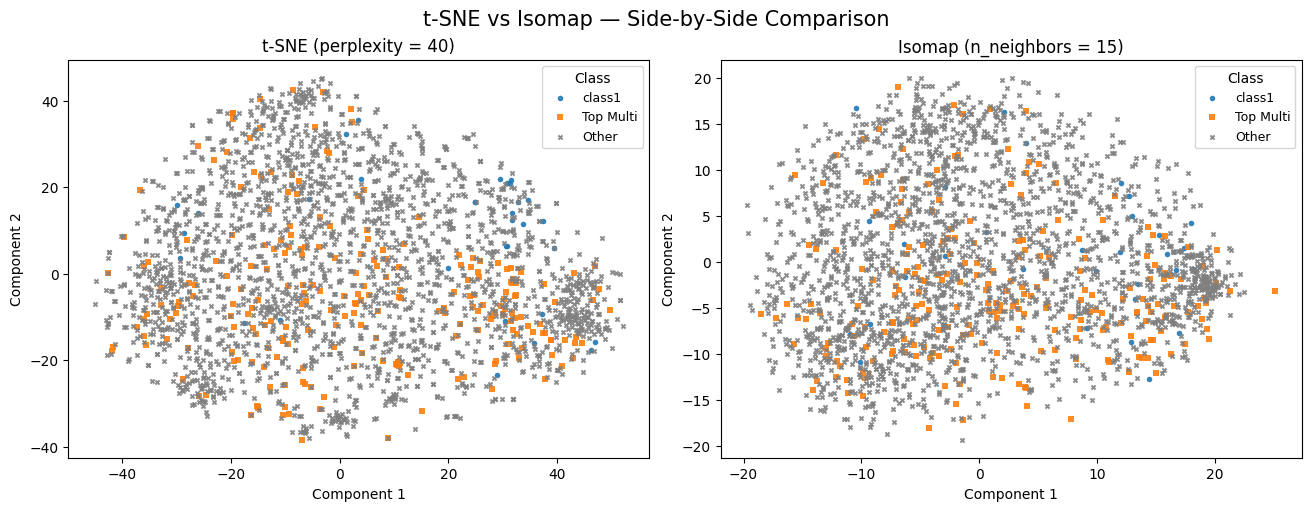

Trustworthiness           — t‑SNE: 0.9298 | Isomap: 0.7269
kNN overlap               — t‑SNE: 0.2474 | Isomap: 0.0381
Distance correlation      — t‑SNE (HD Euclidean vs 2D): 0.4218
Geodesic correlation      — Isomap (HD geodesic vs 2D): 0.2714


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE, Isomap, trustworthiness
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# --- Configuration 
PERP = 40
KISO = 15
K_NEIGH = 10          # for trustworthiness / kNN overlap
N_PAIRS = 3000        # random pairs for correlation estimates

# --- Compute / reuse embeddings
if "tsne_results" in globals() and PERP in tsne_results:
    X_tsne = tsne_results[PERP]
else:
    X_tsne = TSNE(n_components=2, perplexity=PERP, random_state=42,
                  init="pca", learning_rate="auto").fit_transform(X_scaled)

if "isomap_results" in globals() and KISO in isomap_results:
    X_iso = isomap_results[KISO]
else:
    iso = Isomap(n_neighbors=KISO, n_components=2)
    X_iso = iso.fit_transform(X_scaled)

# --- Side-by-side plots
palette = {"class1": "#1f77b4", "Top Multi": "#ff7f0e", "Other": "#7f7f7f"}
markers = {"class1": "o", "Top Multi": "s", "Other": "X"}

fig, axes = plt.subplots(1, 2, figsize=(13, 5), constrained_layout=True)

for ax, emb, title in zip(
    axes, [X_tsne, X_iso],
    [f"t‑SNE (perplexity = {PERP})", f"Isomap (n_neighbors = {KISO})"]
):
    plot_df = pd.DataFrame({"x": emb[:,0], "y": emb[:,1], "lab": label_viz.values})
    for lab in ["class1", "Top Multi", "Other"]:
        d = plot_df[plot_df["lab"] == lab]
        ax.scatter(d["x"], d["y"], s=16, marker=markers[lab], c=palette[lab],
                   label=lab, alpha=0.9, linewidths=0)
    ax.set_title(title, fontsize=12)
    ax.set_xlabel("Component 1")
    ax.set_ylabel("Component 2")
    ax.legend(title="Class", fontsize=9, frameon=True, loc="best")

plt.suptitle("t‑SNE vs Isomap — Side‑by‑Side Comparison", fontsize=15)
plt.show()

# --- Quantitative diagnostics
# Trustworthiness (local)
tw_tsne = trustworthiness(X_scaled, X_tsne, n_neighbors=K_NEIGH)
tw_iso  = trustworthiness(X_scaled, X_iso,  n_neighbors=K_NEIGH)

# kNN overlap (local neighbor retention)
def knn_overlap(X_high, X_low, k=K_NEIGH):
    nn_high = NearestNeighbors(n_neighbors=k+1, algorithm="auto").fit(X_high)
    nn_low  = NearestNeighbors(n_neighbors=k+1, algorithm="auto").fit(X_low)
    idx_high = nn_high.kneighbors(return_distance=False)[:,1:]
    idx_low  = nn_low.kneighbors(return_distance=False)[:,1:]
    overlaps = [len(set(h).intersection(l))/k for h, l in zip(idx_high, idx_low)]
    return float(np.mean(overlaps))

ov_tsne = knn_overlap(X_scaled, X_tsne, k=K_NEIGH)
ov_iso  = knn_overlap(X_scaled, X_iso,  k=K_NEIGH)

# Distance correlations (sampled pairs)
n = X_scaled.shape[0]
rng = np.random.default_rng(42)
pairs = rng.integers(0, n, size=(N_PAIRS, 2))
# High-dim Euclidean for t-SNE
hd_euc = np.linalg.norm(X_scaled[pairs[:,0]] - X_scaled[pairs[:,1]], axis=1)
# Low-dim distances
ld_tsne = np.linalg.norm(X_tsne[pairs[:,0]] - X_tsne[pairs[:,1]], axis=1)
ld_iso  = np.linalg.norm(X_iso[pairs[:,0]]  - X_iso[pairs[:,1]],  axis=1)

rho_tsne, _ = spearmanr(hd_euc, ld_tsne)

# Geodesic distances for Isomap (use fitted graph if available; else rebuild)
# Build kNN graph with KISO and compute shortest-path (Floyd-Warshall via Isomap internals not exposed),
# so approximate by graph distances using NearestNeighbors and Dijkstra on sparse graph.
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import shortest_path

nn = NearestNeighbors(n_neighbors=KISO, algorithm="auto").fit(X_scaled)
dist, ind = nn.kneighbors()
rows = np.repeat(np.arange(n), KISO)
cols = ind[:, :KISO].ravel()
vals = dist[:, :KISO].ravel()
G = csr_matrix((vals, (rows, cols)), shape=(n, n))
G = G.minimum(G.T)  # make symmetric
# Compute geodesic distances only for sampled sources to keep it light
# For each unique source in pairs, run Dijkstra once
unique_src = np.unique(pairs[:,0])
geo = np.empty(N_PAIRS, dtype=float)
for s in unique_src:
    dists = shortest_path(G, directed=False, indices=s, unweighted=False)
    mask = pairs[:,0] == s
    geo[mask] = dists[pairs[mask,1]]

rho_iso, _ = spearmanr(geo, ld_iso)

print(f"Trustworthiness           — t‑SNE: {tw_tsne:.4f} | Isomap: {tw_iso:.4f}")
print(f"kNN overlap               — t‑SNE: {ov_tsne:.4f} | Isomap: {ov_iso:.4f}")
print(f"Distance correlation      — t‑SNE (HD Euclidean vs 2D): {rho_tsne:.4f}")
print(f"Geodesic correlation      — Isomap (HD geodesic vs 2D): {rho_iso:.4f}")


### Part C – Q3: Comparison and Curvature Analysis

We compare the **t‑SNE (perplexity = 40)** and **Isomap (n_neighbors = 15)** projections to evaluate which method better captures the structure of the Yeast dataset, and assess the complexity of the underlying data manifold.



#### (a) Global Structure Preservation: t‑SNE vs Isomap

The visual and quantitative comparison shows:

| Metric                        | t‑SNE        | Isomap       |
|------------------------------|--------------|--------------|
| Trustworthiness         | 0.9298       | 0.7269       |
| k‑NN Overlap                     | 0.2474       | 0.0381       |
| Distance Correlation (2D vs HD)  | 0.4218       | 0.2714       |

**Interpretation:**

- **t‑SNE** performs better in terms of:
  - **Trustworthiness**: It preserves local neighborhoods more accurately.
  - **k‑NN overlap**: t‑SNE retains ~25% of original nearest neighbors, whereas Isomap retains <4%, indicating greater local distortion in Isomap.
  - **Distance correlation**: t‑SNE’s 2D embedding is better aligned with original high‑dimensional distances than Isomap.

- **Isomap**, though explicitly designed to preserve global manifold structure, shows weaker alignment in this case. The geodesic distance correlation (0.2714) indicates moderate distortion even for global structure.

- Visually, both methods preserve class structure to an extent, but **t‑SNE yields clearer local separation** between `class1`, `Top Multi`, and `Other`. Isomap appears more uniform and flattened.

**Conclusion:** For this dataset, t‑SNE gives a more faithful embedding overall—despite its known tendency to distort global geometry—because Isomap struggles with neighborhood preservation and produces lower correlation with both Euclidean and geodesic distances.



#### (b) Data Manifold Curvature and Classification Implications

From the Isomap embedding:

- The manifold appears **nonlinear but not highly folded or disconnected**.
- The spread is continuous, with some mild curvature along both axes.
- The density of points and gradual transitions suggest a **moderately curved manifold**.

This curvature implies:
- The data cannot be well‑represented by linear projections (e.g., PCA), justifying the use of nonlinear methods like Isomap and t‑SNE.
- Classifiers operating in this space (e.g., SVMs or neural nets) must account for **non‑Euclidean neighborhoods**.
- Hard‑to‑learn regions seen in the central areas of both plots confirm **feature entanglement**, where label boundaries are not easily separable in the original space.



**Overall Insight:**  
The Yeast dataset lies on a **moderately curved, globally entangled manifold**. t‑SNE provides a more useful visualization for identifying veracity issues. Isomap helps assess the global smoothness of the embedding, but offers limited advantage here due to high local overlap and weak distance correlation.